In [1]:
import os
import cv2
import yaml
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

module = '/home/yunpeng/Penn-Courses/f1/learning_adaptive_safety/f1tenth_racetracks_overrides/General1'
print(module)
input_map_id = "0"
input_map = "General1_map"

def pixel2meter(path, height, s, tx, ty):
    path = path.astype(float)
    new_path_x = path[:, 0] * s + tx
    new_path_y = (height - path[:, 1]) * s + ty
    if path.shape[1] > 2:
        new_right_dist = path[:, 2] * s
        new_left_dist = path[:, 3] * s
        return np.vstack((new_path_x, new_path_y, new_right_dist, new_left_dist)).T
    else:
        return np.vstack((new_path_x, new_path_y)).T

def meter2pixel(path, height, s, tx, ty):
    path = path.astype(float)
    new_path_x = (path[:, 0] - tx) / s
    new_path_y = height - (path[:, 1] - ty) / s
    if path.shape[1] > 2:
        new_right_dist = path[:, 2] / s
        new_left_dist = path[:, 3] / s
        return np.vstack((new_path_x, new_path_y, new_right_dist, new_left_dist)).T
    else:
        return np.vstack((new_path_x, new_path_y)).T


def read_centerline(input_map_id):
    input_map = "map" + input_map_id
    csv_file_path = os.path.join(module, input_map + ".csv")
    centerline = np.genfromtxt(csv_file_path, delimiter=",")
    return centerline

def draw_centerline(input_map_id):
    input_map = "map_obs" + input_map_id
    csv_file_path = os.path.join(module, "map" + input_map_id + ".csv")
    yaml_file = os.path.join(module, f"map{input_map_id}.yaml")
    with open(yaml_file, 'r') as stream:
        parsed_yaml = yaml.safe_load(stream)
    scale = parsed_yaml["resolution"]
    offset_x = parsed_yaml["origin"][0]
    offset_y = parsed_yaml["origin"][1]
    img_path = os.path.join(module, input_map + ".png")

    # read a color image
    input_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    h, w = input_img.shape[:2]
    print("Map Metadata: ", h, w, scale, offset_x, offset_y)
    centerline = np.genfromtxt(csv_file_path, delimiter=",")
    centerline_xy = centerline[:, :2]
    centerline_pixel = meter2pixel(centerline_xy, h, scale, offset_x, offset_y)

    # imshow the centerline use dot and red color
    for i in range(len(centerline_pixel)):
        input_img[int(centerline_pixel[i][1]), int(centerline_pixel[i][0])] = (0, 0, 255)
    cv2.imshow("centerline", input_img)
    cv2.waitKey(0)

def centerline2frenet(input_map_id, centerline, wp_dist):
    input_map = "map_obs" + input_map_id
    x = centerline[:, 0]  # (n, )
    y = centerline[:, 1]
    span = centerline[0, 2]  # Assume constant width for the track
    # Ensure the last point is identical to the first point
    x[-1] = x[0]
    y[-1] = y[0]
    # Recompute distances and cumulative distances
    distances = np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2)  # (n-1, )
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)  # (n, )
    cs_x = CubicSpline(cumulative_distances, x, bc_type='periodic')
    cs_y = CubicSpline(cumulative_distances, y, bc_type='periodic')

    wp_num = round((cumulative_distances.max() - 0) / wp_dist) # number of waypoints
    s_dense = np.linspace(0, cumulative_distances.max(), wp_num)  # (wp_num, )
    x_dense = cs_x(s_dense)  # (wp_num, )
    y_dense = cs_y(s_dense)  # (wp_num, )
    psi = np.arctan2(np.gradient(y_dense), np.gradient(x_dense))
    # Unwrap psi to avoid discontinuity because psi belongs to [-pi, pi]
    psi_unwrapped = np.unwrap(psi)
    kappa = np.gradient(psi_unwrapped) / np.gradient(s_dense)
    w_tr_right = np.ones_like(s_dense) * span
    w_tr_left = np.ones_like(s_dense) * span
    # Create an array of the Frenet points
    frenet_points = np.vstack((s_dense, x_dense, y_dense, psi, kappa, w_tr_right, w_tr_left)).T
    # frenet_points = frenet_points[:-1]

    # Save the Frenet points to a file
    np.savetxt(f'./maps/{input_map}_frenet.csv', frenet_points, delimiter=',', fmt='%.8f',
               header='s_m,x_m,y_m,psi_rad,kappa_radpm,w_tr_right_m,w_tr_left_m')
    return frenet_points


def draw_centerline2(input_map):
    csv_file_path = os.path.join(module, "General1" + "_centerline.csv")
    yaml_file = os.path.join(module, f"{input_map}.yaml")
    with open(yaml_file, 'r') as stream:
        parsed_yaml = yaml.safe_load(stream)
    scale = parsed_yaml["resolution"]
    offset_x = parsed_yaml["origin"][0]
    offset_y = parsed_yaml["origin"][1]
    img_path = os.path.join(module, input_map + ".png")

    # read a color image
    input_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    h, w = input_img.shape[:2]
    print("Map Metadata: ", h, w, scale, offset_x, offset_y)
    centerline = np.genfromtxt(csv_file_path, delimiter=",")
    centerline_xy = centerline[:, :2]
    centerline_pixel = meter2pixel(centerline_xy, h, scale, offset_x, offset_y)

    # imshow the centerline use dot and red color
    for i in range(len(centerline_pixel)):
        input_img[int(centerline_pixel[i][1]), int(centerline_pixel[i][0])] = (0, 0, 255)
    cv2.imshow("centerline", input_img)
    cv2.waitKey(0)

draw_centerline2(input_map)

# centerline = read_centerline(input_map_id)
# centerline = centerline[::2]
# frenet_points = centerline2frenet(input_map_id, centerline, 0.1)
# # Draw the centerline and the frenet points
# plt.figure(figsize=(10, 5))
# plt.plot(centerline[:,0], centerline[:,1], label='Centerline', linewidth=2, color='blue')
# plt.scatter(frenet_points[:,1], frenet_points[:,2], color='red', s=10, label='Frenet Points')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Centerline vs. Frenet Transformation')
# plt.legend()
# plt.axis('equal')
# plt.show()
#
# # Plot 2: Curvature (kappa) and Heading Angle (psi)
# plt.figure(figsize=(10, 5))
# Q = plt.quiver(frenet_points[:,1], frenet_points[:,2], np.cos(frenet_points[:,3]), np.sin(frenet_points[:,3]),
#                frenet_points[:,4], scale=50, headwidth=3, headlength=5, width=0.0025, cmap='jet')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Heading Angle (psi) and Curvature (kappa)')
# plt.colorbar(Q, label='Curvature (kappa)')
# plt.axis('equal')
# plt.show()


/home/yunpeng/Penn-Courses/f1/learning_adaptive_safety/f1tenth_racetracks_overrides/General1
Map Metadata:  323 320 0.05 -8.56 -3.62


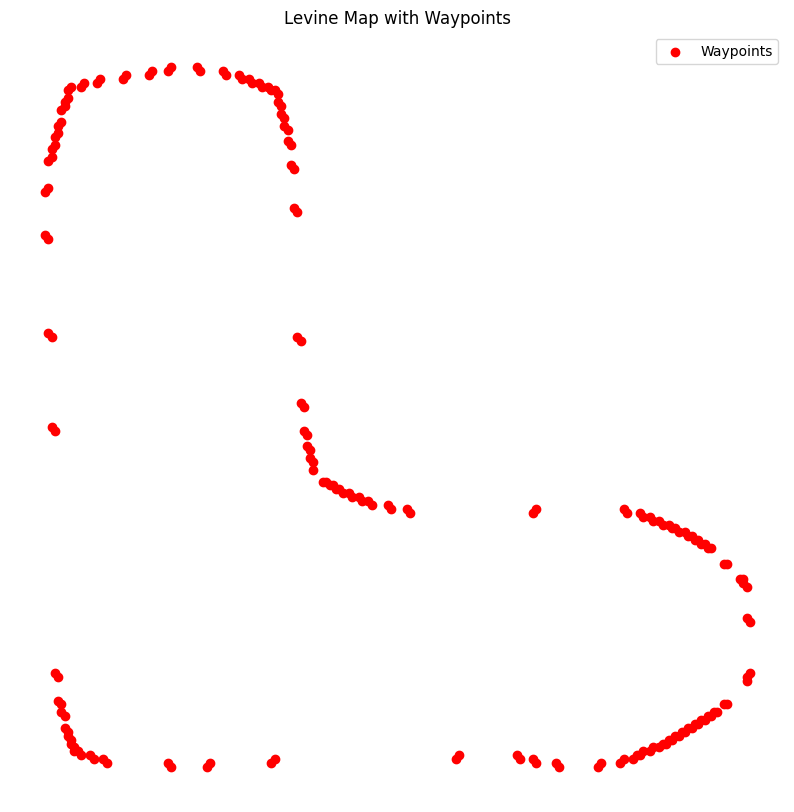

In [2]:
# %matplotlib tk
plt.figure(figsize=(10, 10))
plt.scatter((waypoints_df['world_x'] - levine_origin[0]) / levine_resolution, (waypoints_df['world_y'] - levine_origin[1]) / levine_resolution, c='r', label='Waypoints')
plt.legend()
plt.axis('off')
plt.title('Levine Map with Waypoints')
plt.show()

In [3]:
# centerline_waypoints_path = './General1_centerline.csv'
# centerline_waypoints_df = pd.read_csv(waypoints_path, header=None)
# # set the last two columns (left dis, right dis) to 1.0
# centerline_waypoints_df.iloc[:, 2] = 1.0
# centerline_waypoints_df.iloc[:, 3] = 1.0
# # save the csv file
# centerline_waypoints_df.to_csv(centerline_waypoints_path, header=False, index=False)

In [4]:
# raceline_waypoints_path = './General1_raceline.csv'
# raceline_waypoints_df = pd.read_csv(waypoints_path, header=None)
# # set the last two columns (left dis, right dis) to 1.0
# raceline_waypoints_df.iloc[:, 2] = 1.0
# raceline_waypoints_df.iloc[:, 3] = 1.0
# # save the csv file
# raceline_waypoints_df.to_csv(raceline_waypoints_path, header=False, index=False)